# Imports

In [113]:
import os
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython.display import display

from utils.file_utils import get_model_short_name
from utils_extraction import metrics

In [2]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (8, 8)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [98]:
SAVE_DIR = Path("extraction_results")


DEBERTA = "deberta-v2-xxlarge-mnli"
LLAMA_7B_CHAT = "meta-llama/Llama-2-7b-chat-hf"

DATASET_ORDER = ("imdb", "amazon-polarity", "ag-news", "dbpedia-14", "copa", "rte", "boolq", "qnli", "piqa", "all")
METHOD_ORDER = ("CCS", "LR", "Random", "CCS-md", "LR-md", "Random-md", "RCCS")

# Utils

In [119]:
# Data loading and preprocessing


def load_eval_csvs(
    save_dir,
    experiment_name,
    model_filter=None,
    train_set_filter=None,
    eval_set_filter=None,
    use_latest_run_id: bool = True,
    use_best_in_domain_acc: bool = True,
):
    base_path = Path(save_dir) / experiment_name
    csv_files = base_path.glob(
        "**/eval.csv"
    )  # Use glob to find all eval.csv files recursively

    all_data = []
    for csv_file in csv_files:
        # Extract components from the path
        parts = csv_file.parts
        train_set = parts[-6]
        seed = parts[-5].split("_")[-1]
        run_id = parts[-4]
        eval_dataset = parts[-2]

        # Read the CSV
        df = pd.read_csv(csv_file)

        # Sanity checks
        if not all(df["train"] == train_set) or not all(
            df["test"] == eval_dataset
        ):
            raise ValueError(f"Sanity check failed for {csv_file}")

        # Add new columns
        df["save_dir"] = save_dir
        df["experiment_name"] = experiment_name
        df["seed"] = int(seed)
        df["run_id"] = int(run_id)

        all_data.append(df)

    # Concatenate all dataframes
    final_df = pd.concat(all_data, ignore_index=True)

    # Optional filtering
    if model_filter:
        final_df = final_df[final_df["model"] == model_filter]
    if train_set_filter:
        final_df = final_df[final_df["train"] == train_set_filter]
    if eval_set_filter:
        final_df = final_df[final_df["test"] == eval_set_filter]

    if use_latest_run_id:
        final_df = get_latest_run_id_df(final_df)
    if use_best_in_domain_acc:
        final_df = get_best_metric_by_acc_df(final_df)

    return final_df


def get_latest_run_id_df(df):
    latest_group_dfs = []
    for key, group_df in df.groupby(
        ["model", "prefix", "method", "train", "test", "seed"]
    ):
        max_run_id = group_df.run_id.max()
        group_df = group_df[group_df.run_id == max_run_id]
        latest_group_dfs.append(group_df)

    latest_run_df = pd.concat(latest_group_dfs, ignore_index=True)

    for key, group_df in latest_run_df.groupby(
        [
            "model",
            "prefix",
            "method",
            "train",
            "test",
            "prompt_level",
            "location",
            "layer",
            "seed",
        ]
    ):
        num_unique_run_ids = group_df.run_id.nunique()
        if num_unique_run_ids != 1:
            raise ValueError(
                f"Expected 1 unique run_id, but got {num_unique_run_ids} for {key}"
            )

    return latest_run_df


def get_dataset_names_from_str(train_sets_str: str) -> list[str]:
    return train_sets_str.split("+")


def get_best_metric_by_acc_df(df):
    """Flip metrics for each experiment if it improves in-domain accuracy.

    Use the in-domain accuracy to decide whether to flip the accuracy instead of
    computing max(acc, 1-acc) for test datasets even if the in-domain accuracy
    is greater than 0.5. Also flips the ECE if the flipped accuracy is better.

    In-domain accuracy for a given dataset is computed as the mean accuracy over
    all the prompts when evaluated on that same dataset. The model, prefix,
    method, token location, layer, and seed are held constant.
    """
    processed_df = []
    for key, train_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "train",
            "location",
            "layer",
            "seed",
        ]
    ):
        assert len(train_df["train"].unique()) == 1
        train_ds_str = train_df["train"].iloc[0]
        train_ds_list = get_dataset_names_from_str(train_ds_str)

        if not train_ds_list:
            raise ValueError(f"No train datasets found for {key}")

        # If trained on multiple datasets, uses the mean accuracy on
        # those datasets to decide whether to flip the accuracy. Otherwise,
        # uses the accuracy of the single dataset.
        in_domain_train_df = train_df[train_df["test"].isin(train_ds_list)]
        group_num_unique_in_domain_prompts = (
            in_domain_train_df.prompt_level.nunique()
        )
        num_unique_in_domain_prompts = df[
            df["test"].isin(train_ds_list)
        ].prompt_level.nunique()
        if group_num_unique_in_domain_prompts != num_unique_in_domain_prompts:
            raise ValueError(
                f"Expected {num_unique_in_domain_prompts} unique "
                f"prompts in the group df for key {key} to match the "
                "number of unique prompt indices in the whole df where "
                f"test == {train_ds_str}, but got "
                f"{group_num_unique_in_domain_prompts}."
            )

        in_domain_acc = in_domain_train_df["accuracy"].mean()
        if in_domain_acc < 0.5:
            train_df["accuracy"] = 1 - train_df["accuracy"]
            train_df["ece"] = train_df["ece_flip"]

        del train_df["ece_flip"]
        processed_df.append(train_df)

    return pd.concat(processed_df)


# Inference

InferenceMethodType = Literal["auto", "mean", "class0", "class1"]


def get_single_class_probs(
    probs_df: np.ndarray,
    method: str,
    inference_method: InferenceMethodType = "auto",
):
    """Returns the predicted probability for a single class."""
    if method == "LR":
        if inference_method not in ("auto", "class1"):
            raise ValueError(
                f"Unsupported inference method {inference_method} for method {method}"
            )
        probs = probs_df.prediction
    elif method == "CCS":
        if inference_method == "auto" or inference_method == "mean":
            # Arbitrarily treat p0 as 0 and p1 as 1 to match the original CCS
            # implementation, which computes (p0 + 1 - p1) / 2 but then checks
            # if this value is < 0.5 intead of > 0.5.
            probs = (probs_df.p1 + 1 - probs_df.p0) / 2
        elif inference_method == "class0":
            probs = probs_df.p0
        elif inference_method == "class1":
            probs = probs_df.p1
    else:
        raise ValueError(f"Unknown method {method}")

    return probs.values.astype(np.float32)


# ECE


def make_ece_df(
    save_dir: str,
    experiment_name: str,
):
    base_path = Path(save_dir) / experiment_name
    probs_files = base_path.glob("**/prob*.csv")

    all_data = []
    for probs_file in probs_files:
        # Extract components from the path
        parts = probs_file.parts
        model = parts[-7]
        train_set = parts[-6]
        seed = int(parts[-5].split("_")[-1])
        run_id = int(parts[-4])
        eval_set = parts[-2]
        probs_str, method, prompt = parts[-1].split(".")[0].split("_")
        prompt = int(prompt)

        # Read the CSV
        df = pd.read_csv(probs_file)

        probs = get_single_class_probs(df, method)
        preds = (probs > 0.5).astype(int)
        labels = df.label.values
        acc = (preds == labels).mean()
        ece, bin_mean_probs, bin_mean_labels = (
            metrics.expected_calibration_error(probs, labels)
        )
        ece_flip, bin_mean_probs_flip, bin_mean_labels_flip = (
            metrics.expected_calibration_error(1 - probs, labels)
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                acc,
                ece,
                bin_mean_probs,
                bin_mean_labels,
                False,
            ]
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                1 - acc,
                ece_flip,
                bin_mean_probs_flip,
                bin_mean_labels_flip,
                True,
            ]
        )

    ece_df = pd.DataFrame(
        all_data,
        columns=[
            "model",
            "method",
            "train",
            "test",
            "prompt",
            "seed",
            "run_id",
            "acc",
            "ece",
            "bin_mean_probs",
            "bin_mean_labels",
            "flip_probs",
        ],
    )
    return ece_df

## Plotting

In [99]:
def plot_heatmap(
    df: pd.DataFrame,
    metric: str,
    std_annot: bool = False,
    heatmap_kwargs: Optional[dict] = None,
):
    # Calculate mean accuracy and standard deviation of accuracy for each combination
    agg_df = (
        df.groupby(["model", "method", "train", "test"])
        .agg(mean=(metric, "mean"), std=(metric, "std"))
        .reset_index()
    )

    for model in agg_df.model.unique():
        model_df = agg_df[agg_df["model"] == model]
        methods = model_df.method.unique()
        # Sort methods by METHOD_ORDER.
        methods = sorted(methods, key=lambda x: METHOD_ORDER.index(x))
        for method in methods:
            df = model_df[model_df["method"] == method]
            if len(df) == 0:
                continue

            # Modify the pivot table creation to include both mean accuracy and std accuracy in the annotations
            pivot_table_mean = df.pivot("train", "test", "mean").reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )
            pivot_table_std = df.pivot("train", "test", "std").reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )

            # Reorder the pivot tables according to DATASET_ORDER
            pivot_table_mean_ordered = pivot_table_mean.reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )
            pivot_table_std_ordered = pivot_table_std.reindex(
                index=DATASET_ORDER, columns=DATASET_ORDER
            )

            # Combine mean and std into a single string for each cell annotation
            annotations = pivot_table_mean_ordered.applymap("{:.2f}".format)
            if std_annot:
                annotations += "+-" + pivot_table_std.applymap("{:.2f}".format)
                annot_size = 6
            else:
                annot_size = 10

            # Create the heatmap with custom annotations
            plt.figure(figsize=(10, 8))
            heatmap_kwargs = heatmap_kwargs or {}
            sns.heatmap(
                pivot_table_mean_ordered,
                annot=annotations,
                fmt="",
                cmap="viridis",
                cbar_kws={"label": f"Mean {metric.capitalize()}"},
                annot_kws={"size": annot_size},
                **heatmap_kwargs,
            )

            # Adding title and axis labels
            plt.title(f"{model} - {method} Mean {metric.capitalize()}")
            plt.xlabel("Test Dataset")
            plt.ylabel("Train Dataset")

            # Show the plot
            plt.show()


def calibration_plot(
    probabilities, labels, num_bins=10, title="Calibration Plot"
):
    """
    Create a calibration plot using Seaborn.

    Args:
    - probabilities (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].
    """
    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(
        probabilities, labels, num_bins=num_bins
    )
    calibration_plot_from_bin_xy(
        bin_mean_probs, bin_mean_labels, title=f"{title} (ECE: {ece:.4f})"
    )


def calibration_plot_from_bin_xy(
    bin_mean_probs, bin_mean_labels, title="Calibration Plot", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(x=bin_mean_probs, y=bin_mean_labels, marker="o", ax=ax)
    ax.plot([0, 1], [0, 1], "k--")  # Perfect calibration line
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Mean Label")
    ax.set_title(title)
    ax.grid(True)

# Load data

In [93]:
# Example usage
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_v3"

# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None

df = load_eval_csvs(
    save_dir, experiment_name, model_filter, train_set_filter, eval_set_filter
)

In [94]:
df.query(
    "method == 'CCS' and prompt_level == 0 and train == 'boolq' and seed == 0"
)

,model,prefix,method,prompt_level,train,test,location,layer,accuracy,ece,loss,sim_loss,cons_loss,save_dir,experiment_name,seed,run_id
1720,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,ag-news,decoder,31,0.4350,0.247845,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
1800,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,amazon-polarity,decoder,31,0.9400,0.178035,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
1910,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,boolq,decoder,31,0.4825,0.433998,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2010,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,copa,decoder,31,0.3100,0.361027,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2100,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,dbpedia-14,decoder,31,0.4600,0.205305,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2180,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,imdb,decoder,31,0.8125,0.119612,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2310,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,piqa,decoder,31,0.4600,0.207105,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2420,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,qnli,decoder,31,0.5050,0.262426,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1
2470,meta-llama-Llama-2-7b-chat-hf,normal,CCS,0,boolq,rte,decoder,31,0.5450,0.300318,0.713575,0.467604,0.245971,extraction_results,Llama-2-7b-chat-hf_v3,0,1


# Transfer accuracy

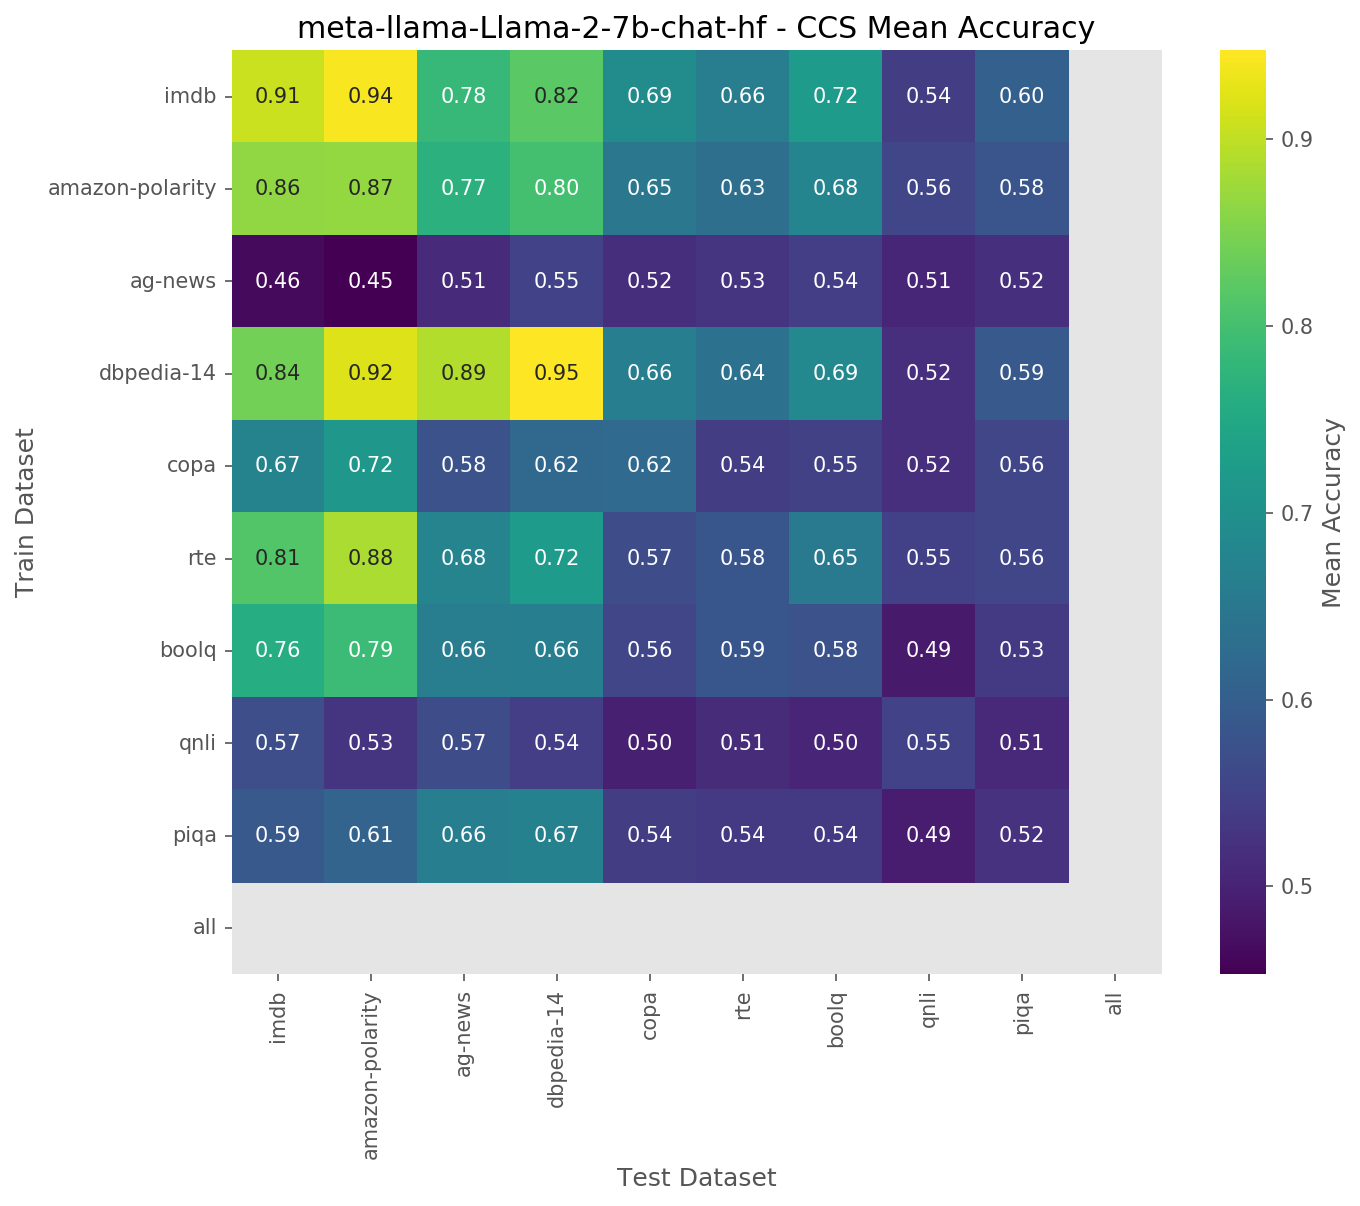

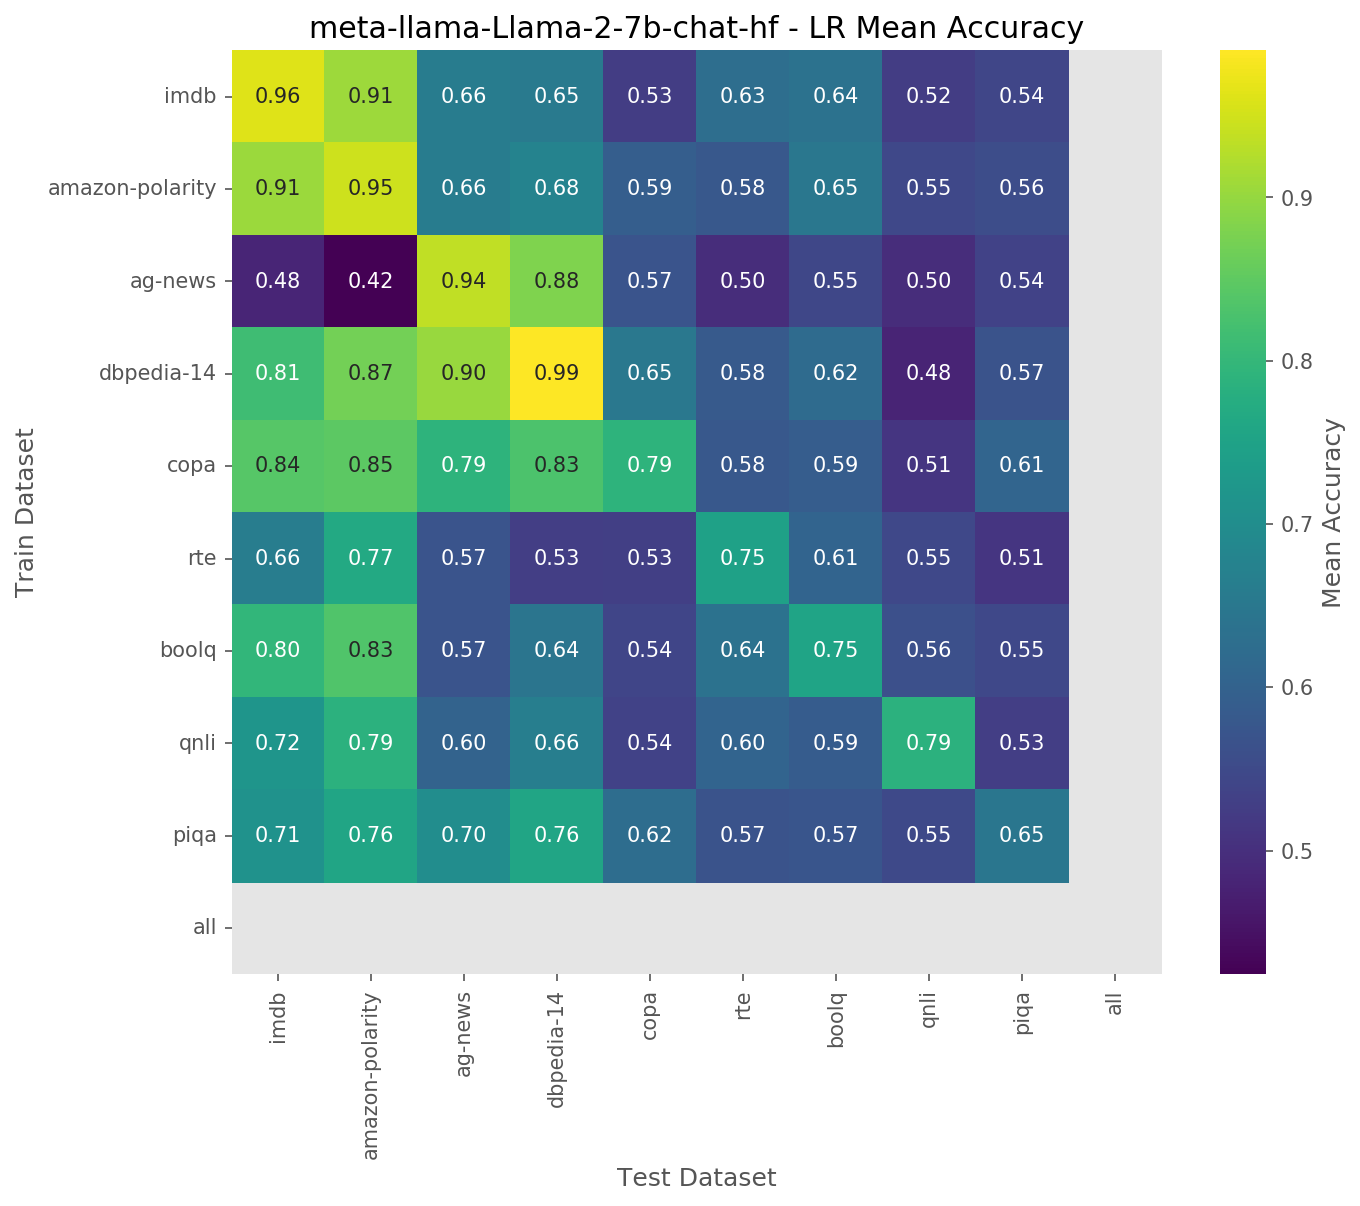

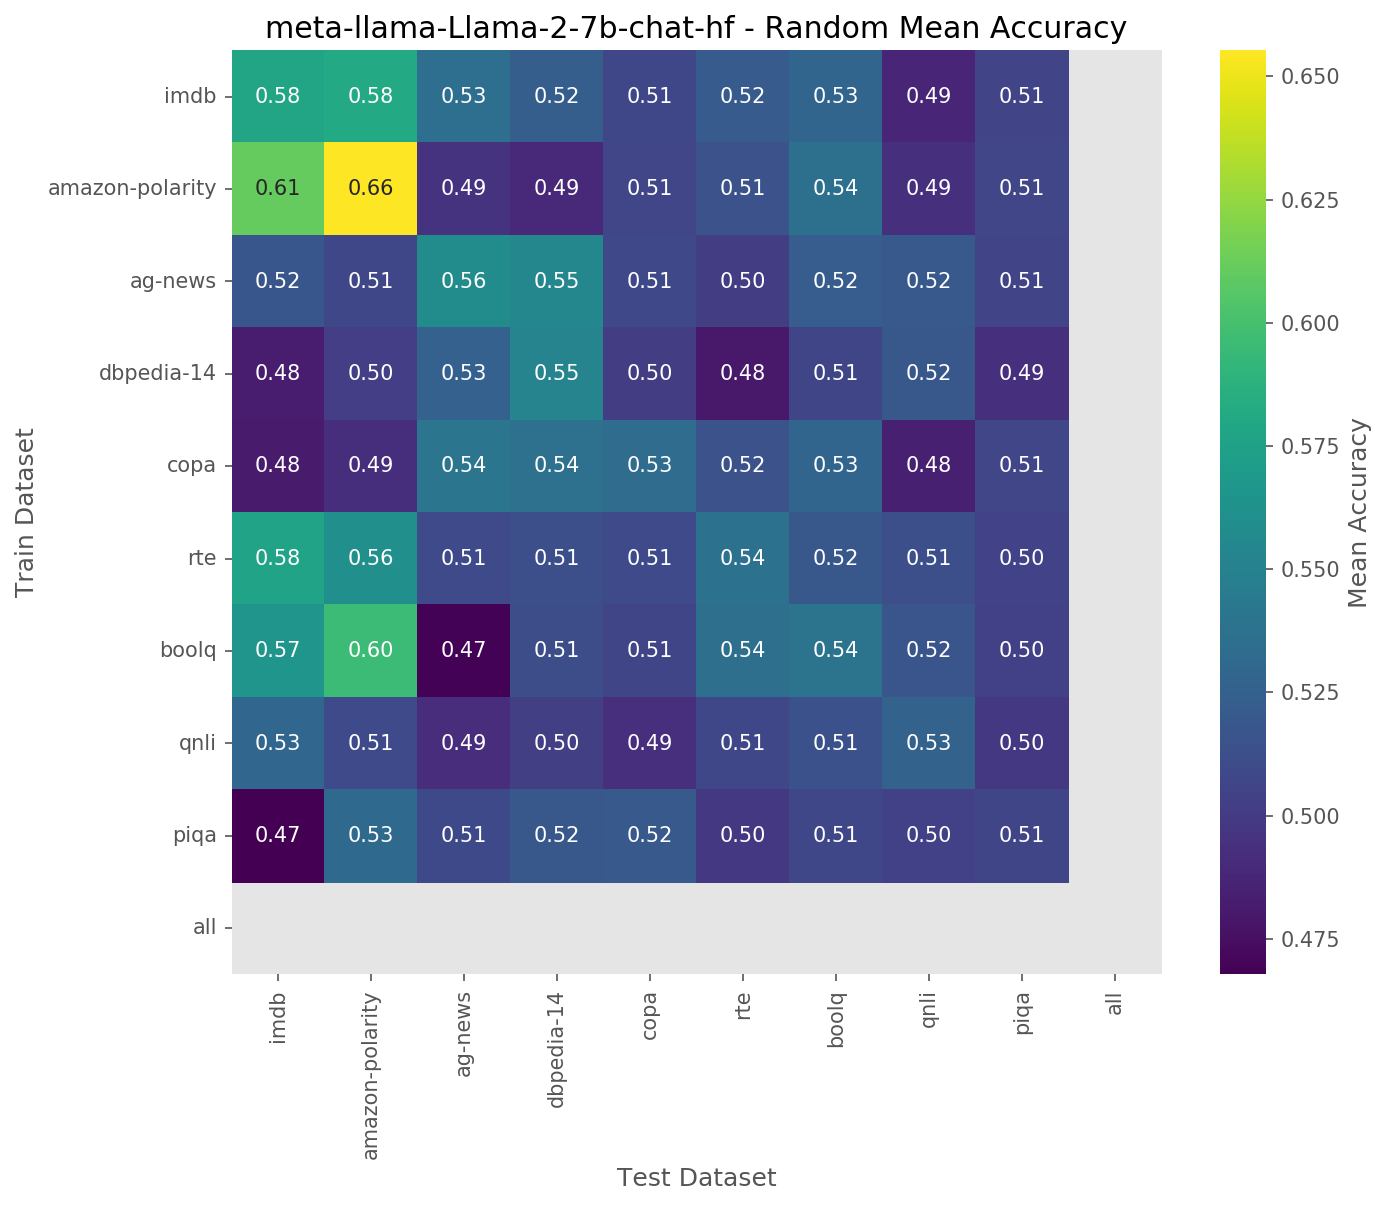

In [100]:
plot_heatmap(df, "accuracy", std_annot=False)

# ECE

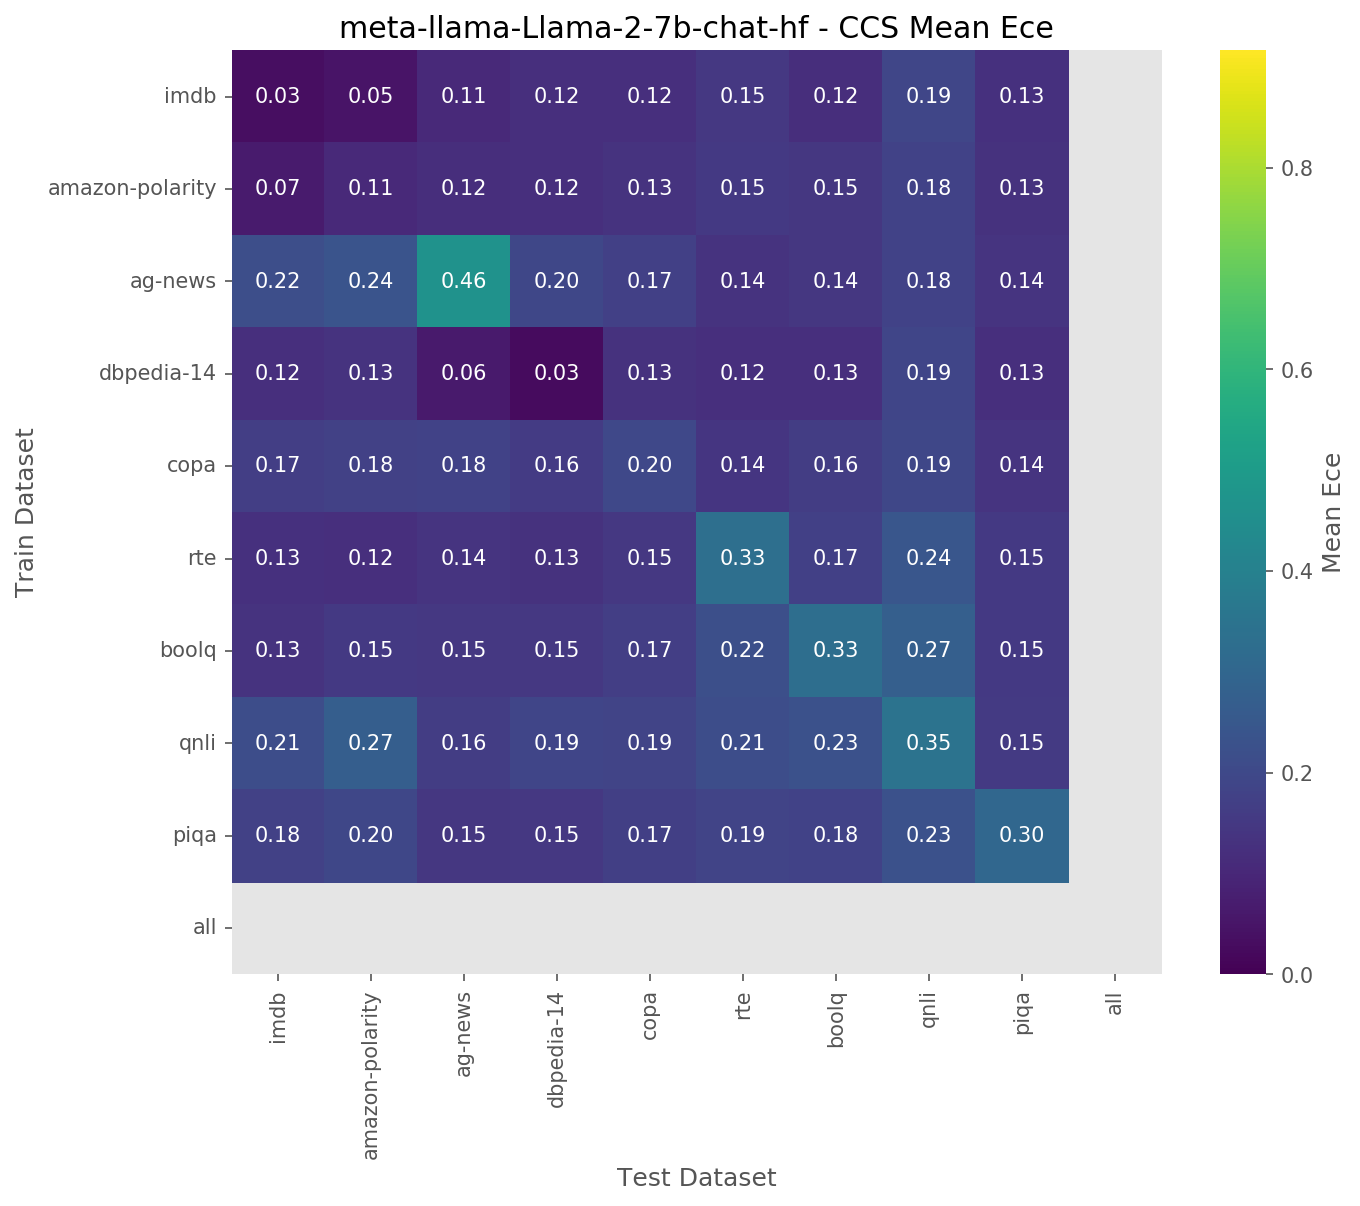

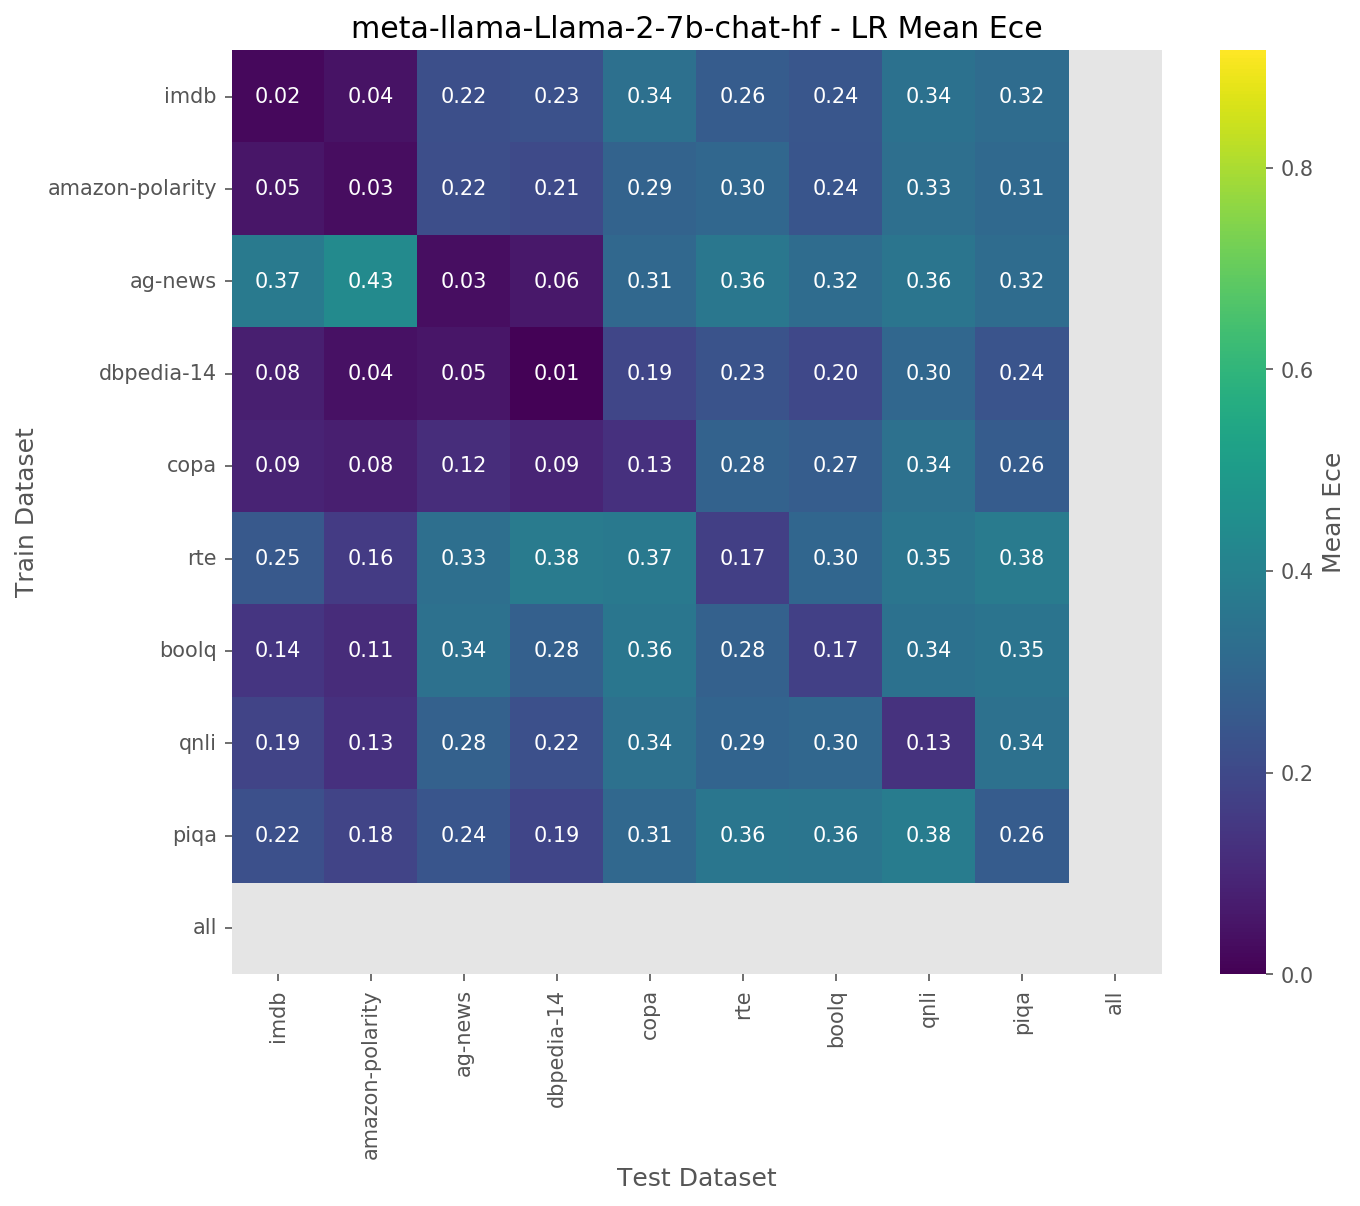

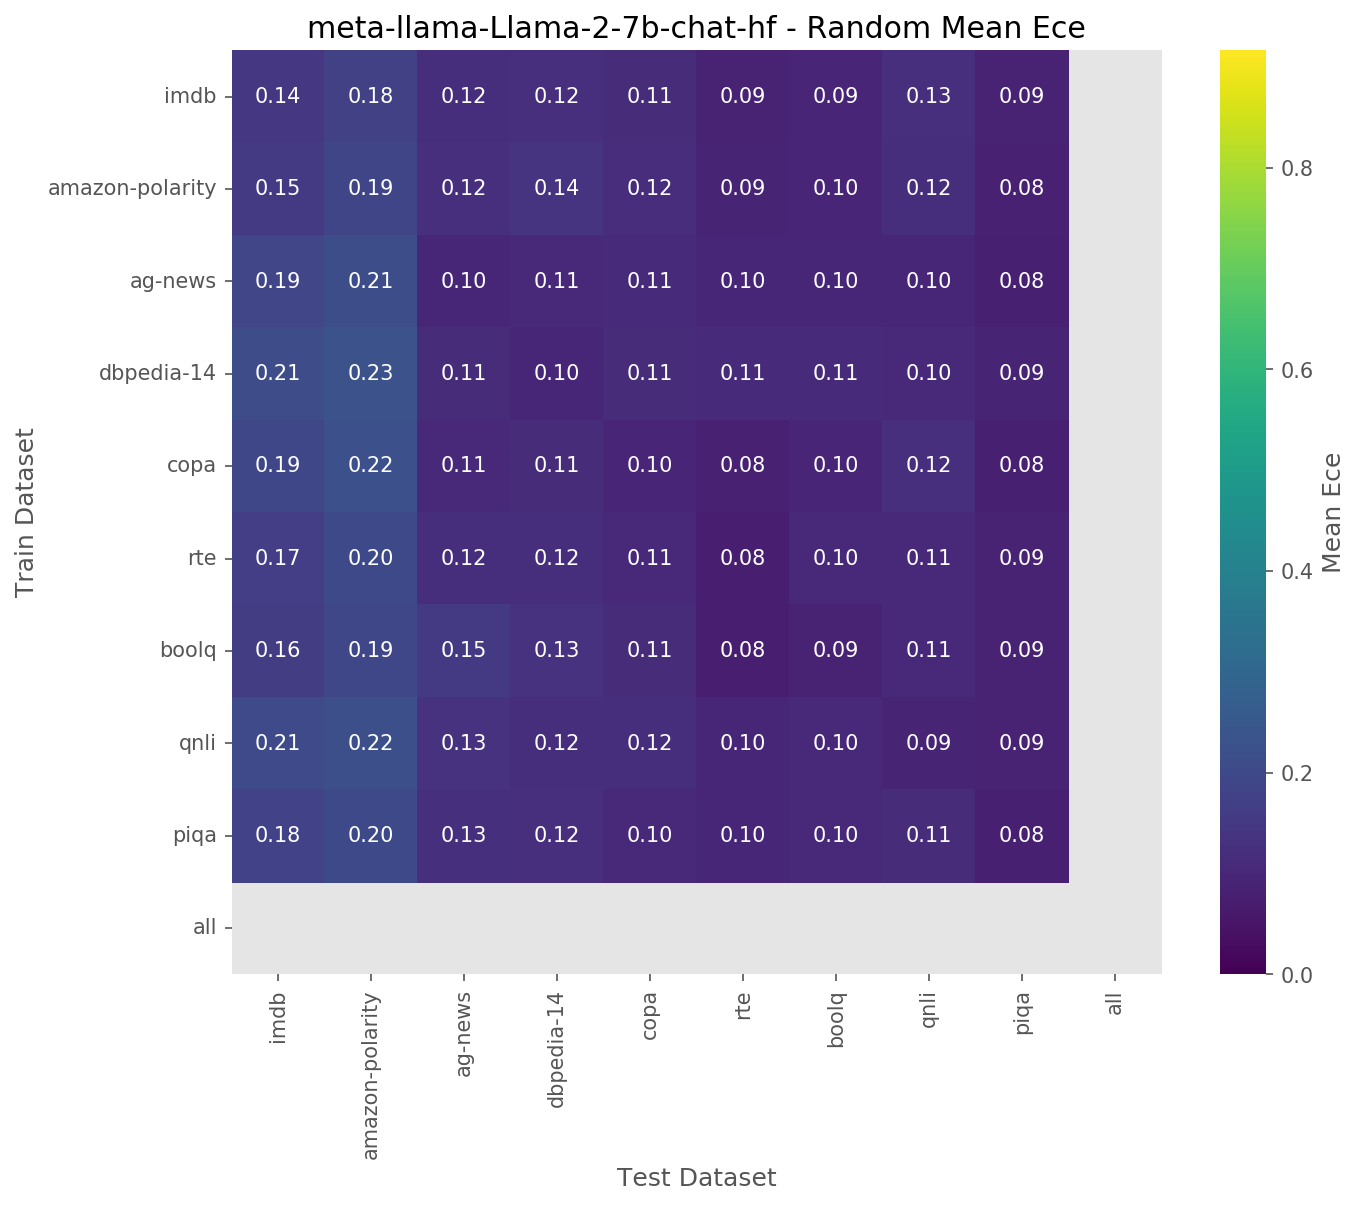

In [101]:
min_ece = df.ece.min()
max_ece = df.ece.max()
heatmap_kwargs = {"vmin": min_ece, "vmax": max_ece}
plot_heatmap(df, "ece", std_annot=False, heatmap_kwargs=heatmap_kwargs)

# Calibration curves

In [120]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_v3"
ece_df = make_ece_df(save_dir, experiment_name)

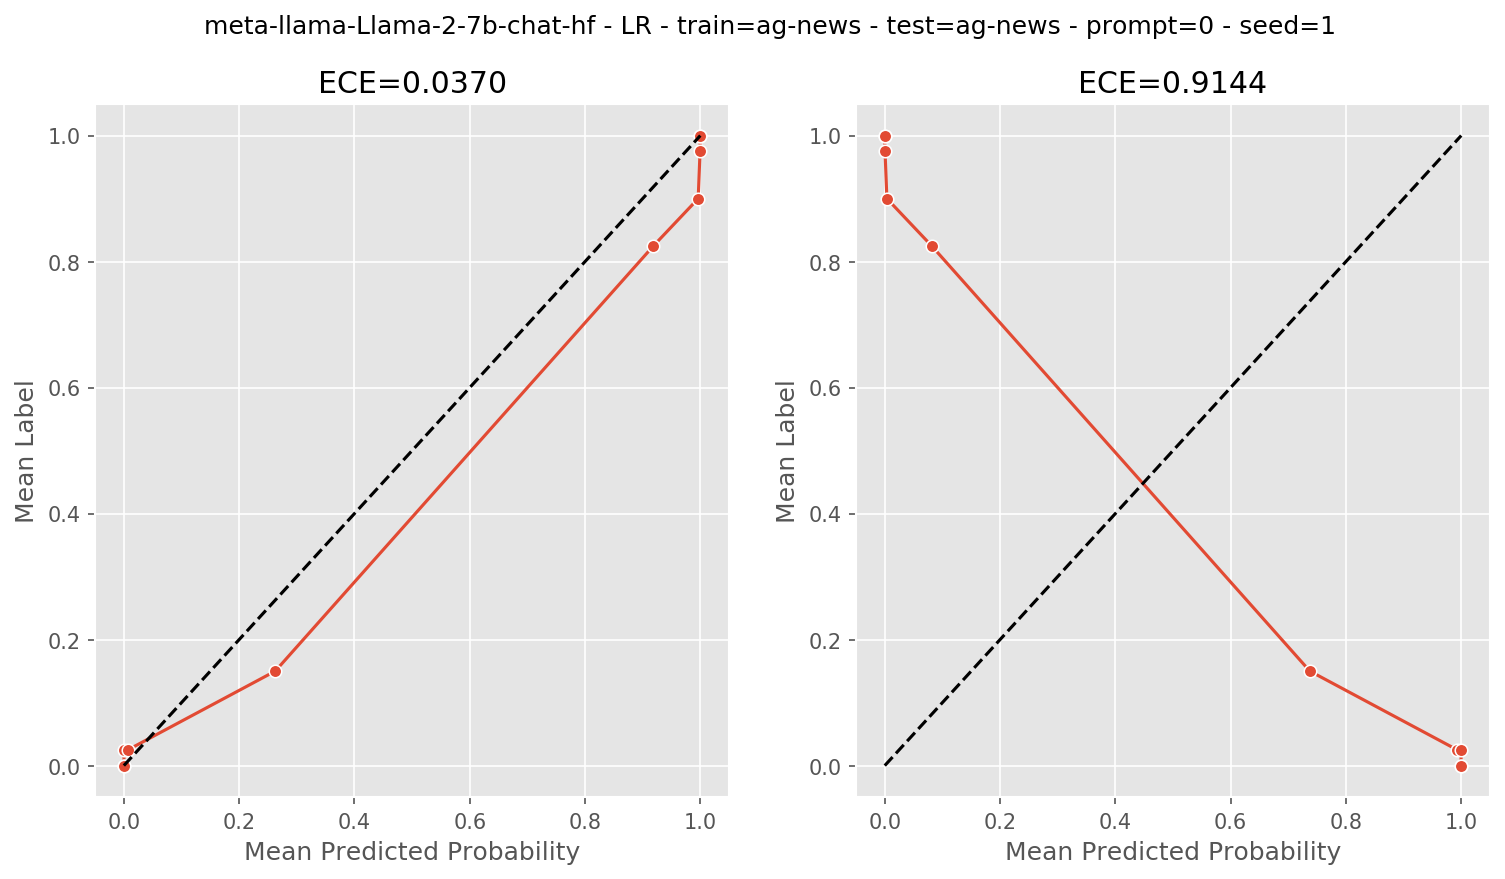

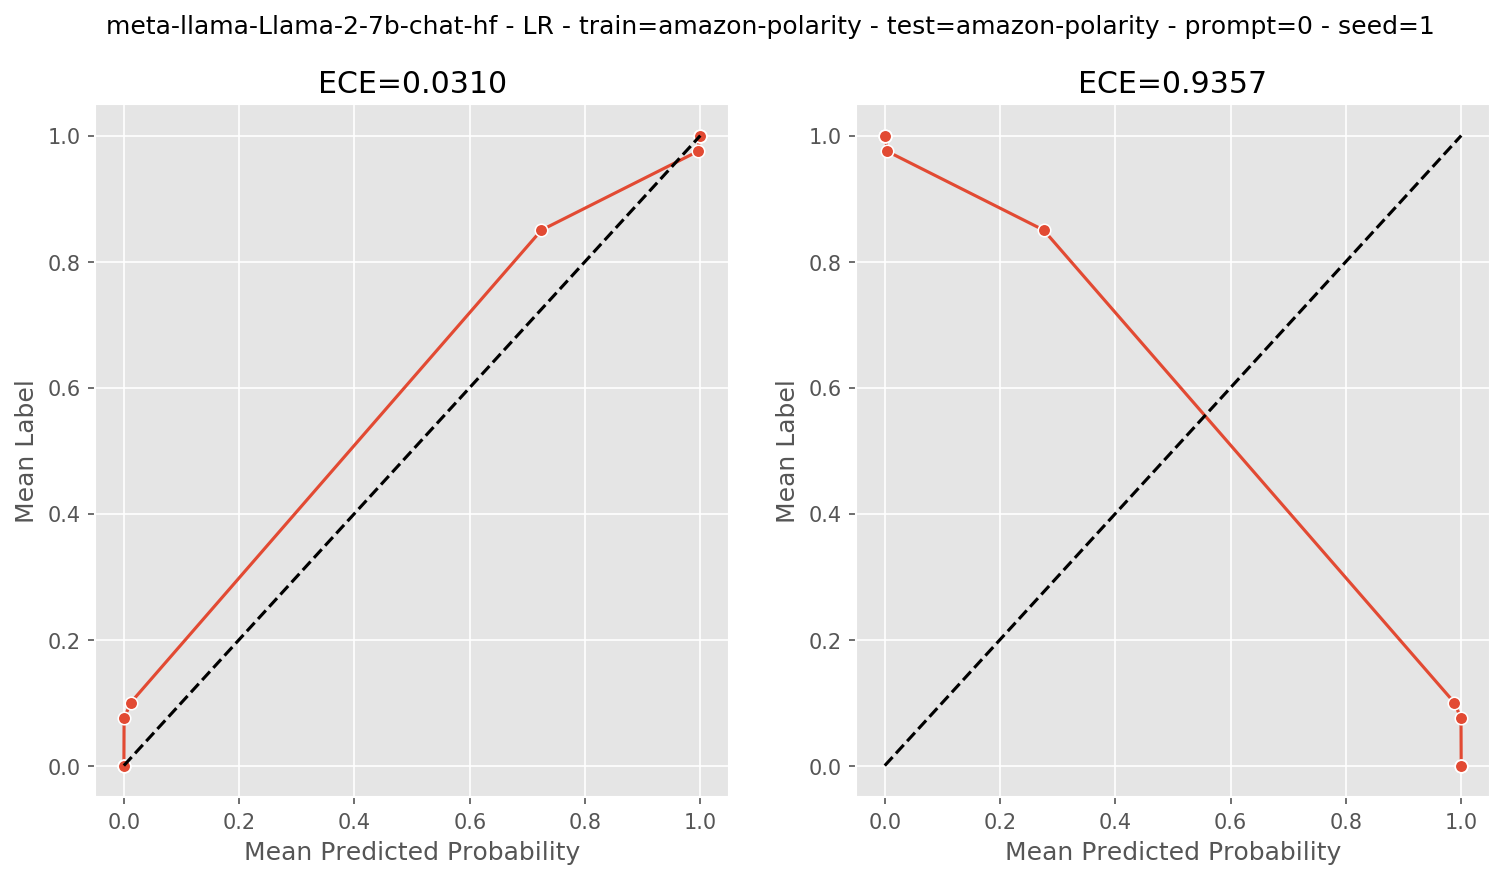

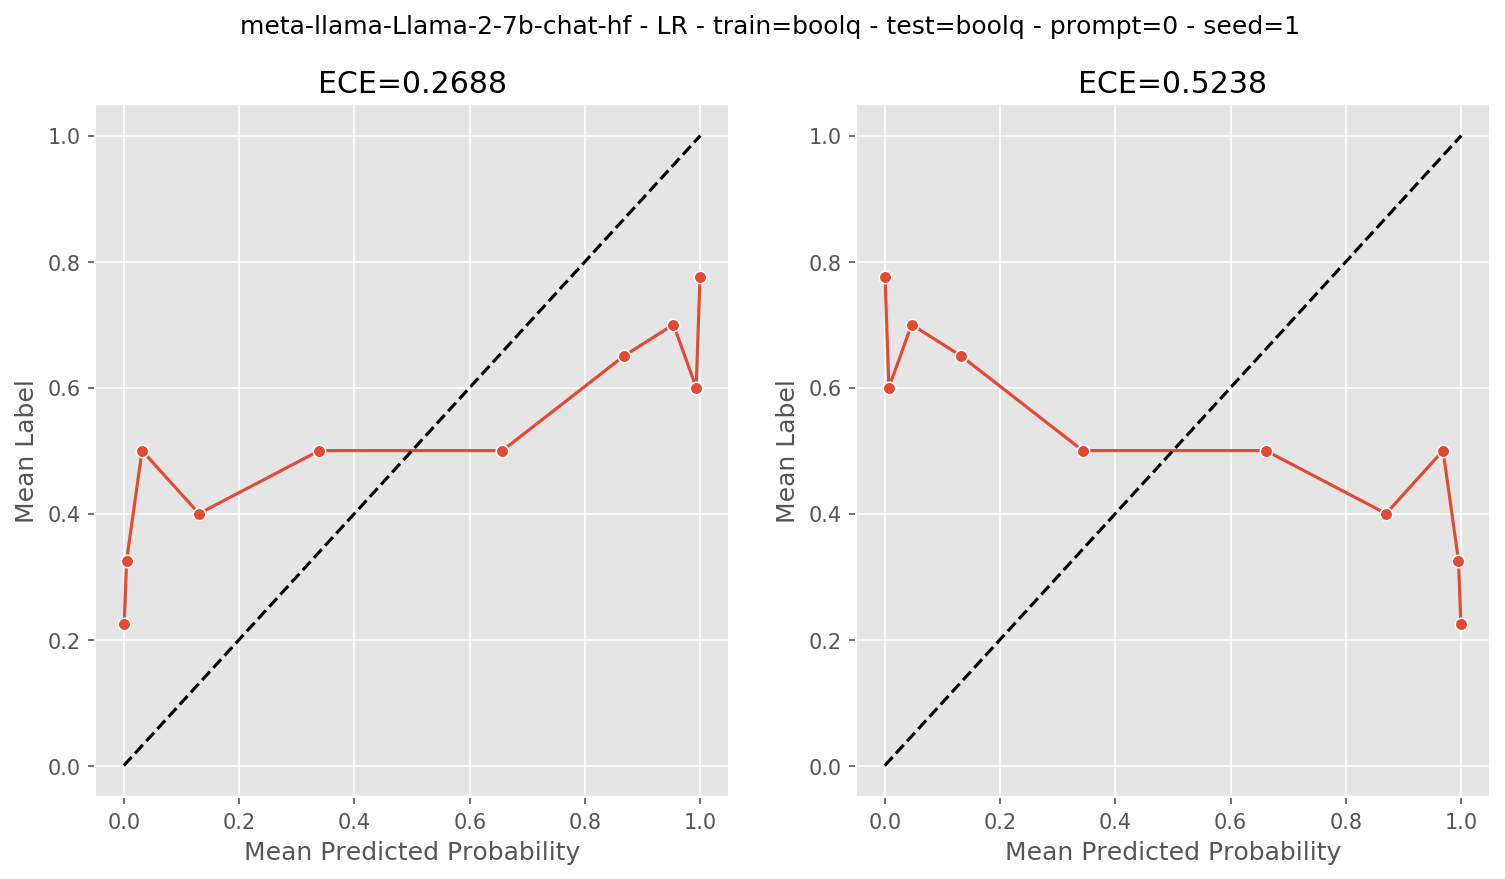

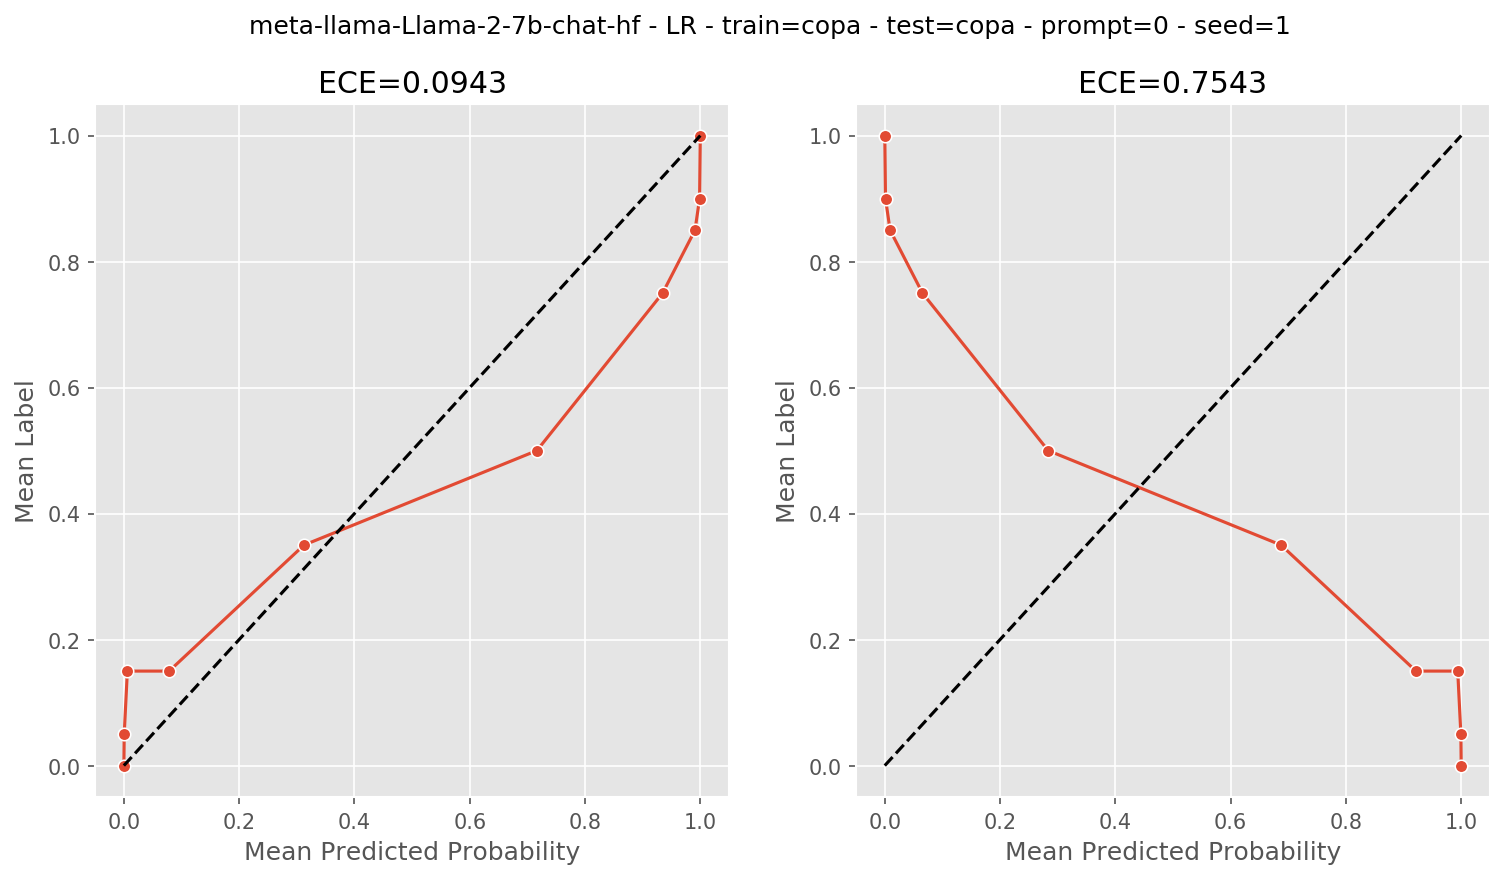

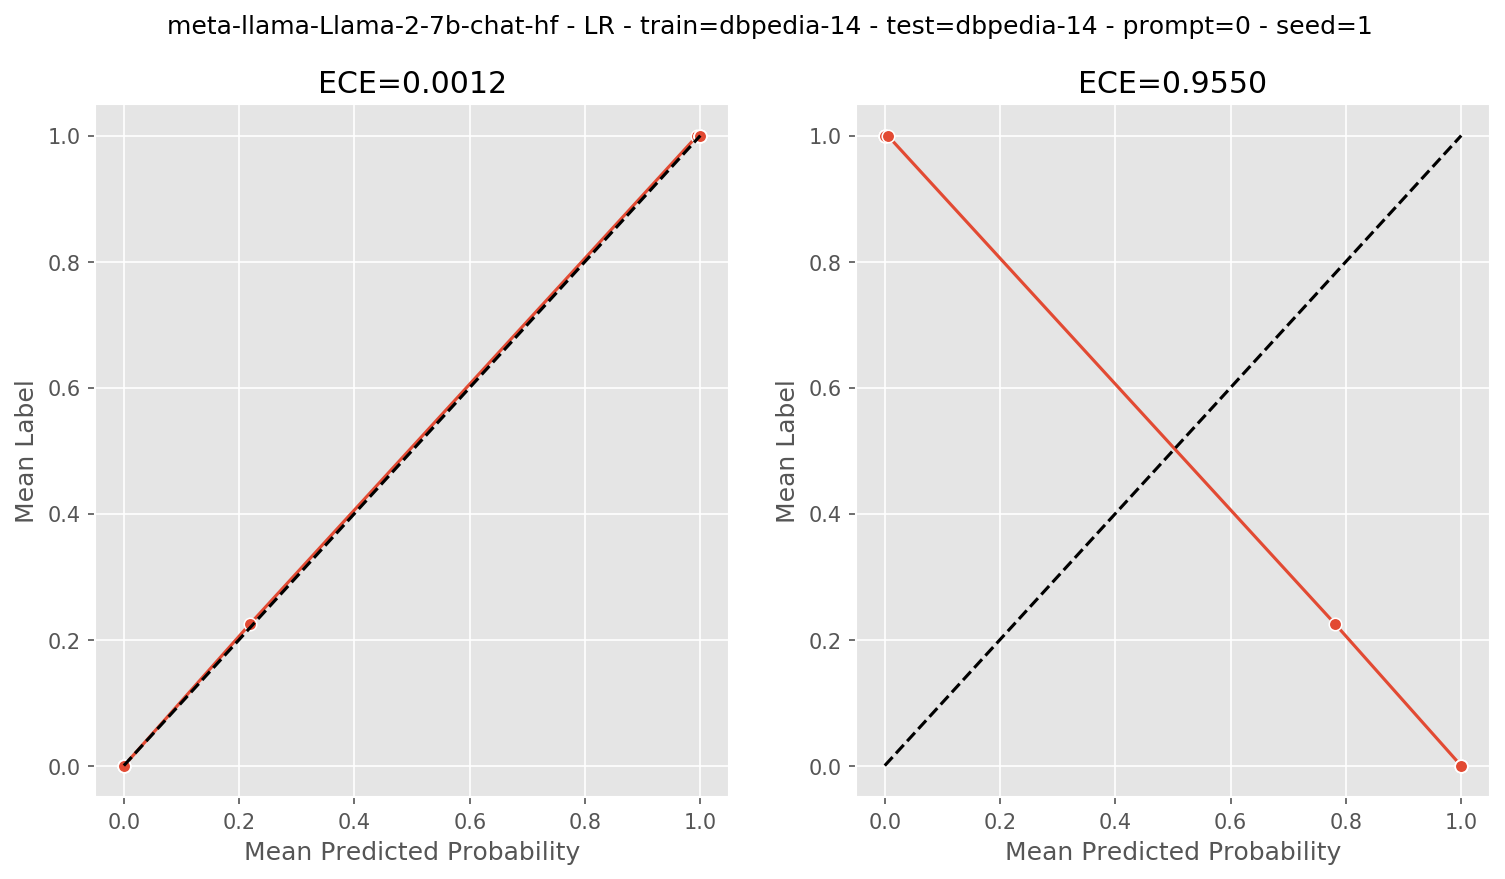

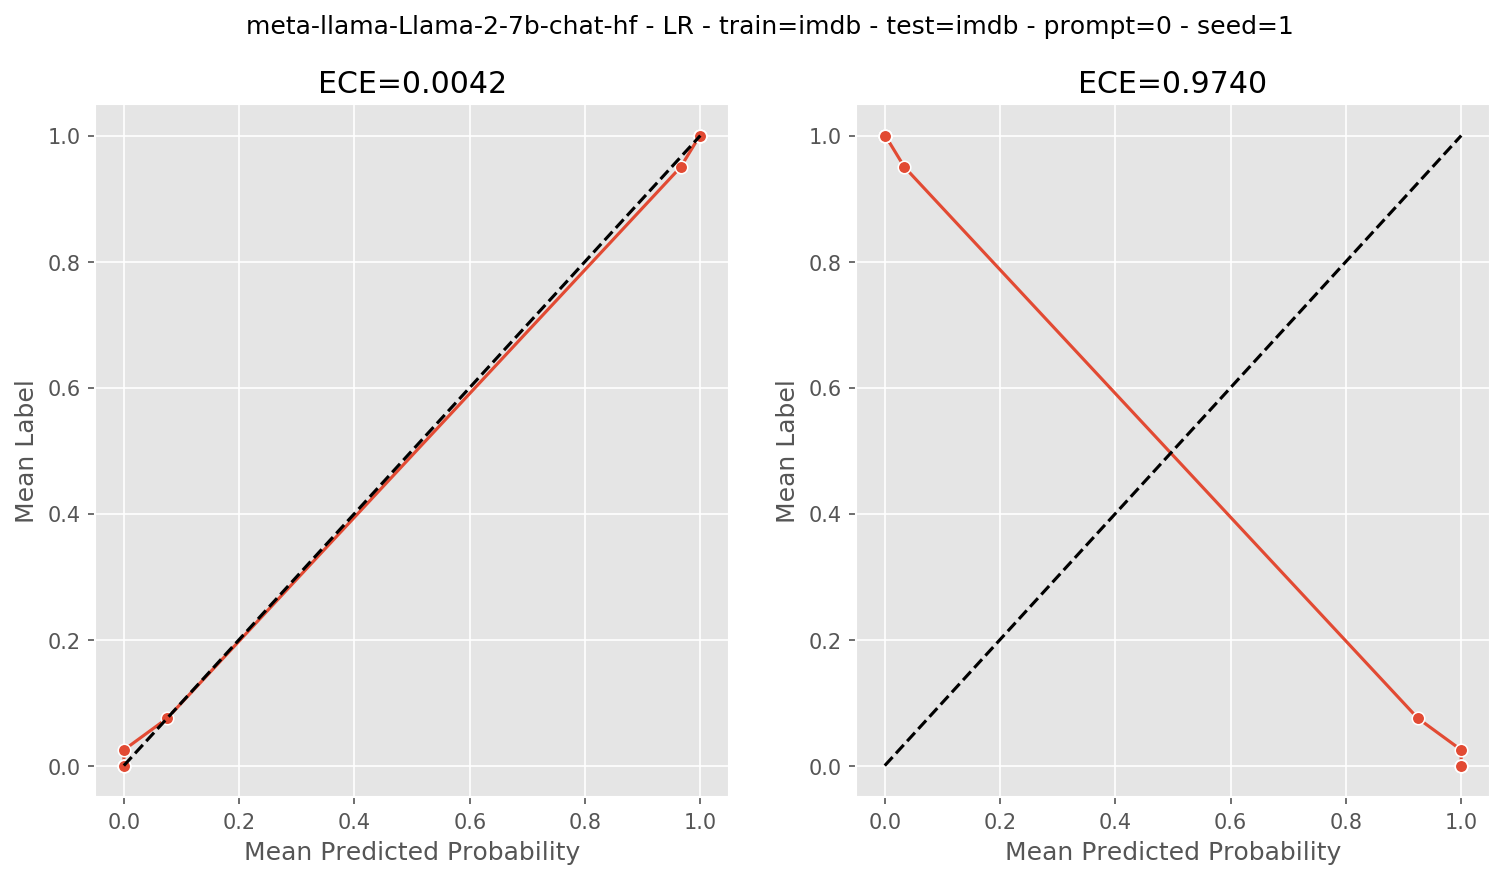

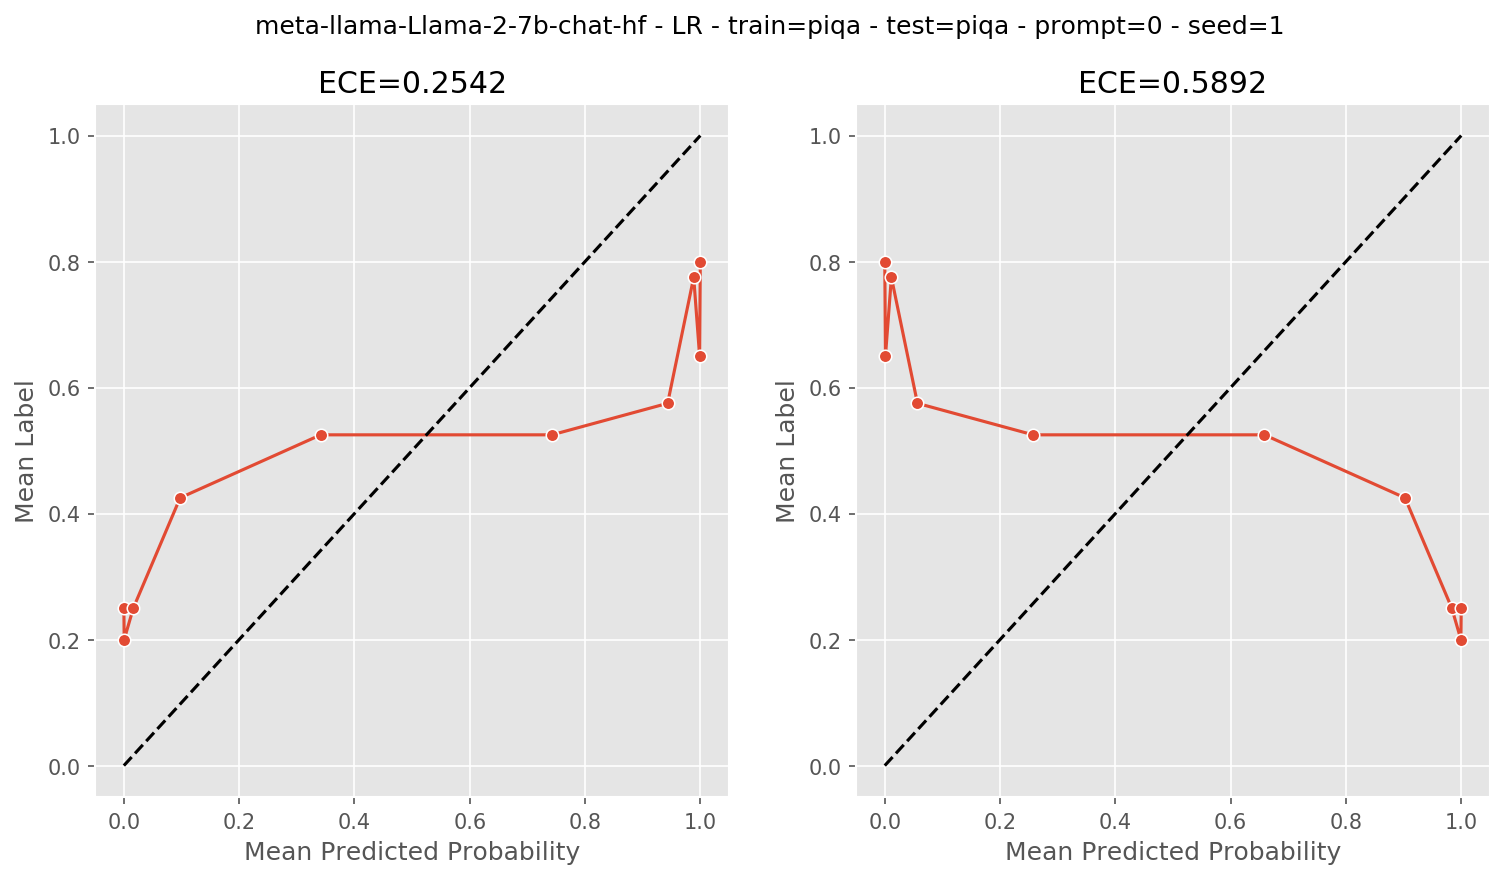

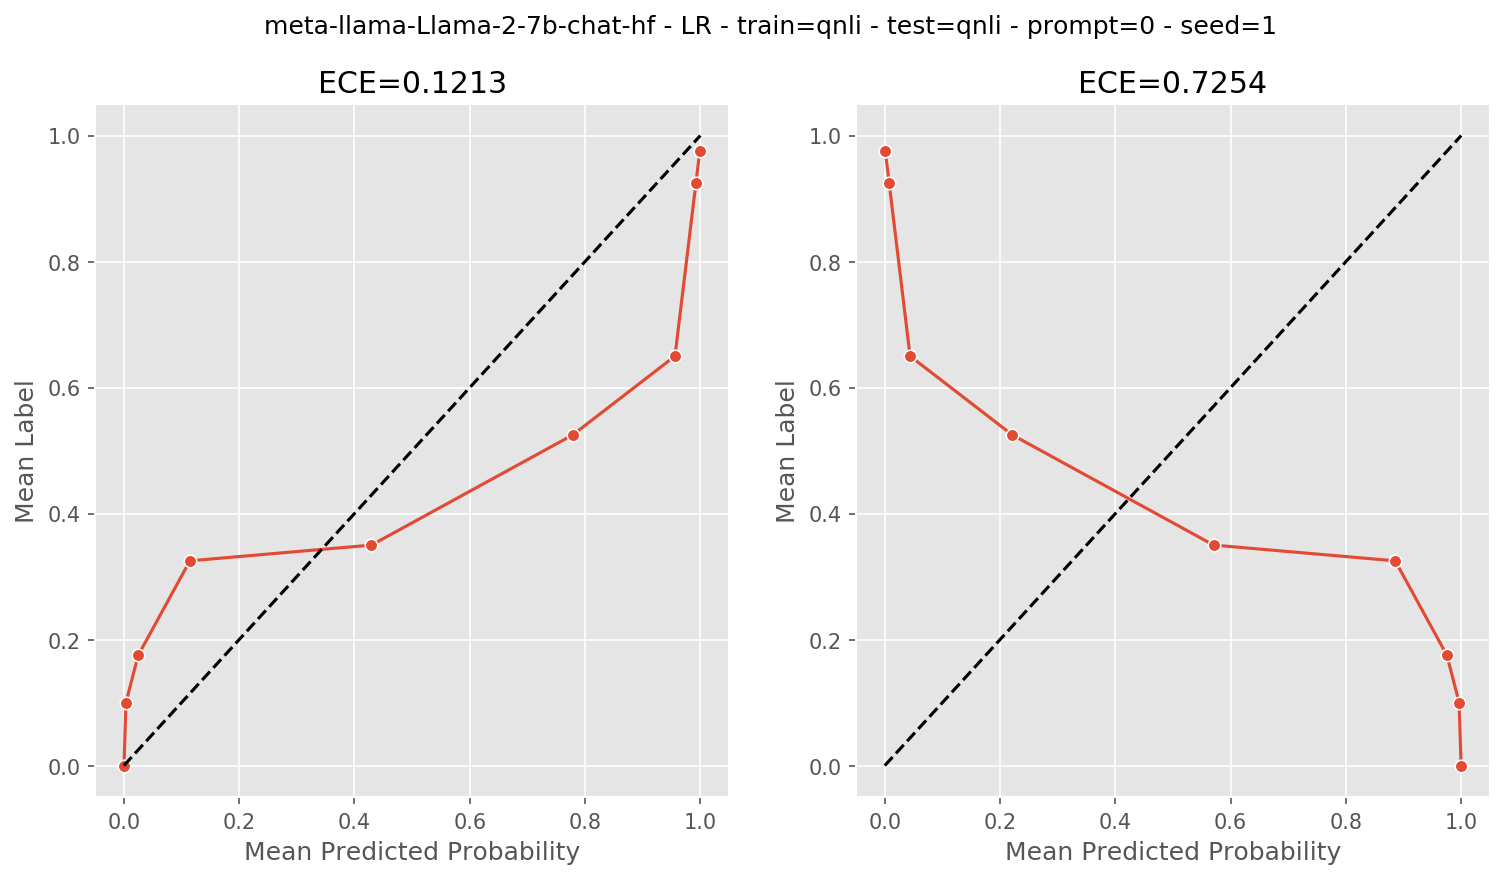

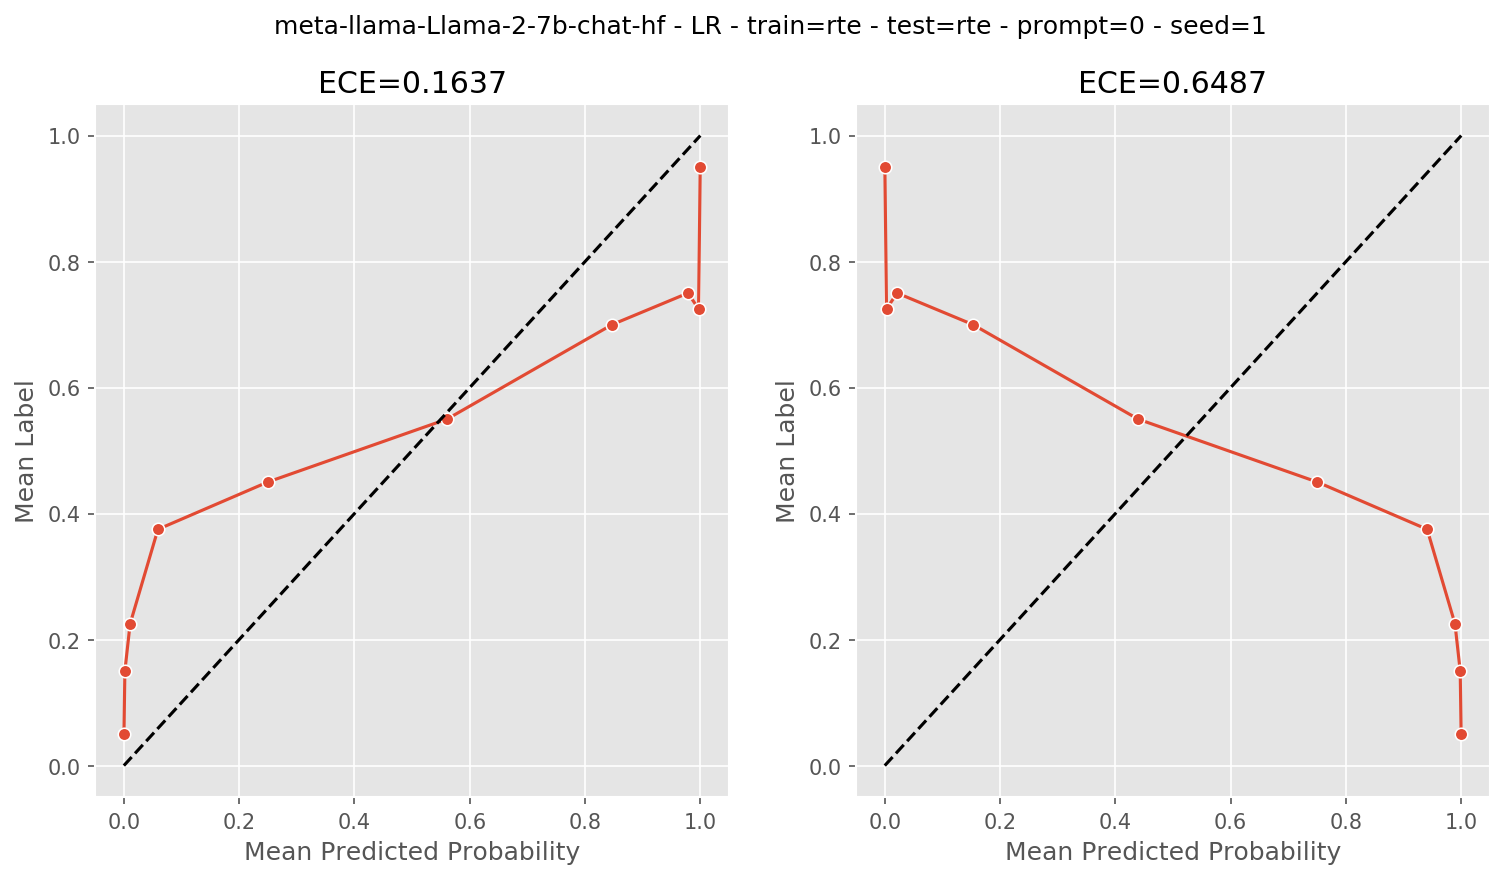

In [ ]:
sample_ece_df = ece_df.query("method == 'CS' and train == test and seed == 1 and prompt == 0")
for key, group_df in sample_ece_df.groupby(["model", "method", "train", "test", "prompt", "seed"]):
    assert len(group_df) == 2
    og_row = group_df[~group_df["flip_probs"]].iloc[0]
    flip_row = group_df[group_df["flip_probs"]].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    og_title = f"ECE={og_row.ece:.4f}"
    calibration_plot_from_bin_xy(og_row.bin_mean_probs, og_row.bin_mean_labels, og_title, ax=ax[0])

    flip_title = f"ECE={flip_row.ece:.4f}"
    calibration_plot_from_bin_xy(flip_row.bin_mean_probs, flip_row.bin_mean_labels, flip_title, ax=ax[1])

    title=f"{og_row.model} - {og_row.method} - train={og_row.train} - test={og_row.test} - prompt={og_row.prompt} - seed={og_row.seed}"
    fig.suptitle(title)